# USING DATA POINTS
#### By - Arnav Ahuja

## Loading data

In [1]:
import pandas as pd
import numpy as np

def load_data(csv_file):
    """
    Loads time series data from a CSV file, assumes the first column contains 
    date/time or sequential information, replaces it with numeric indices, 
    and returns the processed DataFrame along with the index range and time column name.
    
    Parameters:
        csv_file (str): Path to the CSV file.

    Returns:
        df (pd.DataFrame): DataFrame with 'data_point' as the time/index column.
        min_dp (int): Minimum value of the data point index.
        max_dp (int): Maximum value of the data point index.
        time_col (str): Name of the new time/index column ('data_point').
    """
    # Read CSV into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Store the original time column name (assumed to be the first column)
    original_time_col = df.columns[0]
    
    # Rename that column to "data_point" for consistency
    df.rename(columns={original_time_col: "data_point"}, inplace=True)
    
    # Replace its values with sequential integers (0, 1, 2, ...)
    df["data_point"] = list(range(len(df)))
    
    # Get the min and max index values
    min_dp = df["data_point"].min()
    max_dp = df["data_point"].max()
    
    # Return the modified DataFrame and useful metadata
    return df, min_dp, max_dp, "data_point"


## Normalizing data

In [4]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df, time_col="data_point"):
    """
    Cleans and normalizes sensor data in a DataFrame:
      - Drops completely empty rows and columns.
      - Interpolates missing values in numeric columns.
      - Returns only numeric sensor columns along with the time column.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing time and sensor streams.
        time_col (str): The name of the time/index column (default is 'data_point').

    Returns:
        pd.DataFrame: A new DataFrame with interpolated and cleaned numeric columns.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Drop rows that are completely empty
    df.dropna(how='all', inplace=True)

    # Drop columns that are completely empty
    df.dropna(axis=1, how='all', inplace=True)

    # Identify sensor columns (i.e., all columns except the time/index column)
    sensor_cols = [col for col in df.columns if col != time_col]

    # Keep only numeric columns among the sensor columns
    numeric_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

    # Fill missing numeric values using linear interpolation in both directions
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Return DataFrame with the time column and cleaned numeric sensor columns
    return df[[time_col] + numeric_cols]


## Plotting Data

In [6]:
import matplotlib.pyplot as plt

def plot_data(df, plot_type, time_col="data_point"):
    """
    Plots the selected sensor streams using the specified plot type.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time column and sensor data.
        plot_type (str): Type of plot to generate ('line' or 'box').
        time_col (str): Name of the time/index column (default is 'data_point').
    """
    # Extract all stream columns (excluding the time/index column)
    streams = df.columns.drop(time_col)

    if plot_type == "line":
        # Create a line plot for each selected stream
        fig, ax = plt.subplots(figsize=(10, 5))
        for stream in streams:
            ax.plot(df[time_col], df[stream], label=stream)
        ax.set_title("Line Plot of Selected Streams")
        ax.set_xlabel("Data Point")
        ax.set_ylabel("Normalized Values")
        ax.legend()
        fig.tight_layout()
        plt.show()

    elif plot_type == "box":
        # Create a box plot to show distribution of values for each stream
        fig, ax = plt.subplots(figsize=(8, 5))
        df[streams].plot(kind='box', ax=ax)
        ax.set_title("Box Plot of Selected Streams")
        ax.set_ylabel("Normalized Value")
        ax.grid(True)
        plt.show()

    else:
        # Handle unsupported plot types
        print("Unsupported plot type selected.")


## Calculating Correlation

In [9]:
def calculate_pairwise_correlation(df, time_col="data_point"):
    """
    Calculates and prints pairwise Pearson correlations between sensor streams.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time column and sensor data.
        time_col (str): Name of the time/index column (default is 'data_point').
    """
    # Get the list of columns excluding the time/index column
    stream_cols = df.columns.drop(time_col)

    # Check if there are at least two streams to compute correlation
    if len(stream_cols) < 2:
        print("Not enough streams selected to compute correlation.")
        return

    # Print header for correlation output
    print("\nPairwise Correlations (Selected Data Points):")

    # Loop through each unique pair of streams
    for i in range(len(stream_cols)):
        for j in range(i + 1, len(stream_cols)):
            col1, col2 = stream_cols[i], stream_cols[j]
            
            # Compute Pearson correlation between the two streams
            corr = df[col1].corr(df[col2])
            
            # Print the result, removing extra spaces from column names
            print(f"Correlation between {col1.strip()} and {col2.strip()}: {corr:.4f}")


In [10]:
import tkinter as tk
from tkinter import ttk
from datetime import datetime, timedelta

def setup_gui(min_dp, max_dp, sensor_columns, process_callback):
    """
    Sets up the Tkinter GUI for selecting data point range, sensor streams, and plot type.

    Parameters:
        min_dp (int): Minimum value of the data point index.
        max_dp (int): Maximum value of the data point index.
        sensor_columns (list): List of available sensor stream column names.
        process_callback (function): Function to call when the Display button is clicked.

    Returns:
        root (tk.Tk): The root window of the Tkinter interface.
    """
    # Create the main window
    root = tk.Tk()
    root.title("Data Point & Stream Selector + Normalization")
    root.geometry("500x300")
    root.configure(bg="#f9f9f9")

    # Define UI style for consistency
    style = ttk.Style()
    style.configure("TLabel", font=("Segoe UI", 10, "bold"), background="#f9f9f9")
    style.configure("TButton", font=("Segoe UI", 10))
    style.configure("TCheckbutton", font=("Segoe UI", 10), background="#f9f9f9")

    # Start Data Point input
    ttk.Label(root, text="Start Data Point:").grid(row=0, column=0, padx=10, pady=10)
    start_spinbox = ttk.Spinbox(root, from_=min_dp, to=max_dp, width=10)
    start_spinbox.set(min_dp)
    start_spinbox.grid(row=0, column=1)

    # End Data Point input
    ttk.Label(root, text="End Data Point:").grid(row=1, column=0, padx=10, pady=10)
    end_spinbox = ttk.Spinbox(root, from_=min_dp, to=max_dp, width=10)
    end_spinbox.set(max_dp)
    end_spinbox.grid(row=1, column=1)

    # Sensor Stream selection (dynamic checkboxes based on sensor columns)
    ttk.Label(root, text="Select Streams:").grid(row=2, column=0, padx=10, pady=10)
    stream_vars = {}
    for idx, stream in enumerate(sensor_columns):
        var = tk.BooleanVar(value=True)  # default selection is True
        chk = ttk.Checkbutton(root, text=stream, variable=var)
        chk.grid(row=2 + idx // 3, column=1 + idx % 3, sticky="w", padx=5)
        stream_vars[stream] = var  # store the variable for each stream

    # Plot type selection (line or box)
    ttk.Label(root, text="Select Plot Type:").grid(row=5, column=0, padx=10, pady=10)
    plot_type = tk.StringVar(value="line")  # default is line plot
    ttk.Radiobutton(root, text="Line Plot", variable=plot_type, value="line").grid(row=5, column=1, sticky="w")
    ttk.Radiobutton(root, text="Box Plot", variable=plot_type, value="box").grid(row=5, column=2, sticky="w")

    # Define what happens when the user clicks the Display button
    def on_click():
        process_callback(start_spinbox, end_spinbox, stream_vars, plot_type)

    # Display button to trigger the callback
    ttk.Button(root, text="Display", command=on_click).grid(row=6, columnspan=4, pady=20)

    # Return the configured root window
    return root


## Callback function


Pairwise Correlations (Selected Data Points):
Correlation between Temperature (in Celsius) and Humidity (in %): -0.9723

Normalized Data from data point 0 to 766
   data_point  Temperature (in Celsius)  Humidity (in %)
0           0                      23.3             51.6
1           1                      23.3             51.6
2           2                      23.3             51.7
3           3                      23.3             51.8
4           4                      23.3             51.7
Total rows: 767


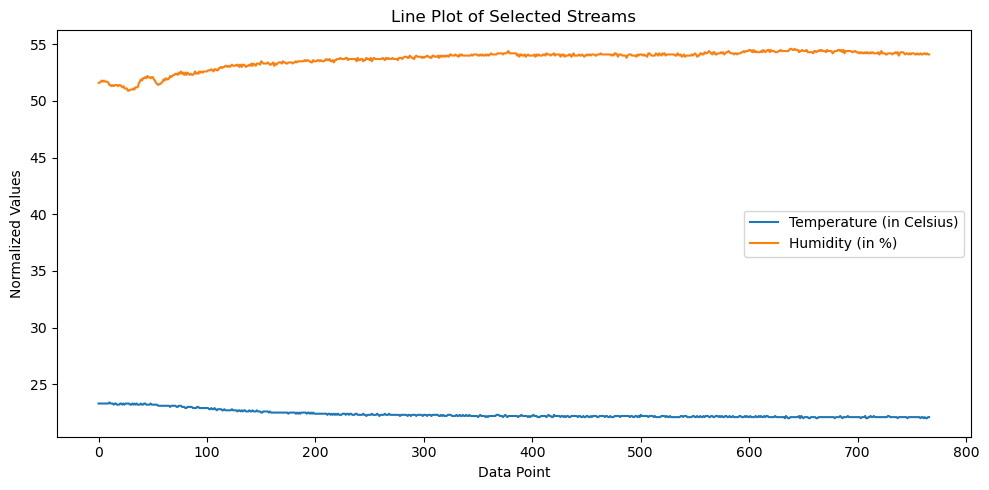

In [15]:
def process_callback(start_spinbox, end_spinbox, stream_vars, plot_type):
    """
    Handles GUI input when the 'Display' button is clicked.
    Extracts the selected data point range and streams, normalizes the data,
    computes correlations, and plots the result.

    Parameters:
        start_spinbox (ttk.Spinbox): Widget for selecting the start data point.
        end_spinbox (ttk.Spinbox): Widget for selecting the end data point.
        stream_vars (dict): Dictionary mapping stream names to their BooleanVar selection.
        plot_type (tk.StringVar): Selected plot type ('line' or 'box').
    """
    try:
        # Get user input from spinboxes and convert to integers
        start_dp = int(start_spinbox.get())
        end_dp = int(end_spinbox.get())
    except ValueError:
        print("Please enter valid integer values for the data point range.")
        return

    # Ensure the start point is less than the end point
    if start_dp >= end_dp:
        print("Start data point must be less than end data point.")
        return

    # Filter the DataFrame based on selected data point range
    df_filtered = df_raw[(df_raw["data_point"] >= start_dp) & (df_raw["data_point"] <= end_dp)]

    # Build a list of selected columns (time + checked sensor streams)
    selected_columns = ["data_point"] + [col for col, var in stream_vars.items() if var.get()]
    df_selected = df_filtered[selected_columns]

    # Normalize and interpolate the selected data
    final_df = normalize_data(df_selected, time_col="data_point")

    # Print pairwise correlation among selected streams
    calculate_pairwise_correlation(final_df, time_col="data_point")

    # Debug: Show preview of the normalized data
    print(f"\nNormalized Data from data point {start_dp} to {end_dp}")
    print(final_df.head())
    print(f"Total rows: {len(final_df)}")

    # Plot the data
    plot_data(final_df, plot_type.get(), time_col="data_point")


# Entry Point
if __name__ == "__main__":
    # Load the dataset from a file (change filename to test other datasets)
    df_raw, min_dp, max_dp, time_col = load_data("sensor_data.csv") 

    # Identify all sensor columns (exclude the time/index column)
    sensor_columns = [col for col in df_raw.columns if col != time_col]

    # Launch the GUI
    root = setup_gui(min_dp, max_dp, sensor_columns, process_callback)
    root.mainloop()
